https://e-dorigatti.github.io/math/deep%20learning/2023/06/25/diffusion.html

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

In [21]:
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

d = 5  # Dimension
n = 10000  # Number of samples from each Gaussian

mean1 = torch.tensor([4.0] * d).to(device)
mean2 = torch.tensor([-4.0] * d).to(device)
std = torch.tensor([1.0] * d).to(device)

gaussian1 = torch.distributions.MultivariateNormal(mean1, torch.diag(std))
gaussian2 = torch.distributions.MultivariateNormal(mean2, torch.diag(std))

samples1 = gaussian1.sample((n,))
samples2 = gaussian2.sample((n,))

dataset = torch.cat((samples1, samples2), dim=0)
labels = torch.cat((torch.zeros(n), torch.ones(n)))

indices = torch.randperm(dataset.size(0))
dataset = dataset[indices]
labels = labels[indices]

cuda


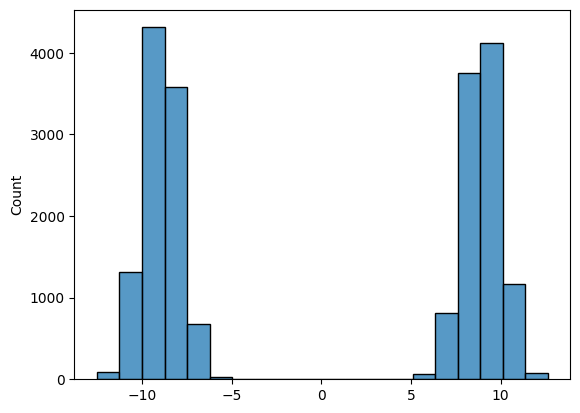

In [22]:
def project (mean1, mean2, data):
    direction_vector = mean1 - mean2
    unit_vector = direction_vector / torch.norm(direction_vector)
    projections = torch.matmul(data, unit_vector)
    return projections

projections = project(mean1, mean2, dataset)
sns.histplot(projections.cpu())
plt.show()

In [23]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = torch.tensor([0.02]).to(device)
CONST = torch.log(torch.sqrt(torch.tensor([2.]) * torch.pi)).to(device)

In [24]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA, d=None,device=device):
    # starting from t=0 (i.e., the dataset)

    samples = [data]
    xt = data

    q = torch.distributions.Normal(
        torch.zeros_like(data).to(device),
        torch.ones_like(data).to(device),
    )
    for t in range(steps):
        xt = q.sample() * torch.sqrt(beta) + xt * torch.sqrt(1-beta)
        samples.append(xt)

    return samples

In [25]:
dataset = dataset.to(device)
samples = do_diffusion(dataset, d=d, device=device)

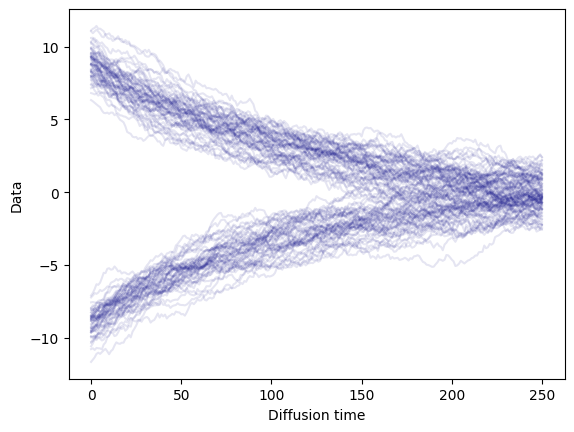

In [26]:
for t in project(mean1, mean2, torch.stack(samples)).T[:100]:
    plt.plot(t.cpu(), c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

In [27]:
import torch.nn.functional as F

def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

In [28]:
def log_prob(sample, loc, scale, const=CONST):
    var = scale ** 2
    log_scale = torch.log(scale).to(device)
    return -((sample - loc) ** 2) / (2 * var) - log_scale - const

In [29]:
forward_samples = dataset
p = torch.distributions.Normal(
torch.zeros(forward_samples[0].shape).to(device),
torch.ones(forward_samples[0].shape).to(device)
)
loss = -p.log_prob(forward_samples[-1]).mean()
print(loss)

tensor(8.4192, device='cuda:0')


In [30]:
forward_samples = dataset
p = torch.distributions.Normal(
torch.zeros(forward_samples[0].shape).to(device),
torch.ones(forward_samples[0].shape).to(device)
)
loss = -p.log_prob(forward_samples[-1]).mean()
print(loss)

mu0, sig0 = torch.zeros(dataset[0].shape).to(device), torch.ones(dataset[0].shape).to(device)
loss = -log_prob(forward_samples[-1], mu0, sig0).mean()
print(loss)

tensor(8.4192, device='cuda:0')
tensor(8.4192, device='cuda:0')


In [31]:
def compute_loss(forward_samples, mean_model, var_model, labels, d, mu0, sig0, beta=BETA):
    # here we compute the loss in equation 3
    # forward = q , reverse = p

    # loss for x(T)
    loss = -log_prob(forward_samples[-1], mu0, sig0).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], d).to(device)),
            dim=1
        )
        # compute p( x(t-1) | x(t) ) as equation 1
        class_info = one_hot_encode(labels.long(), 2).to(device).squeeze()
        # if torch.rand(1).item() < 0.1:
        #     class_info *= 0
            

        inputs = torch.cat((xin, class_info), dim=1)

        mu = mean_model(inputs)
        sigma = var_model(inputs)

        # add a term to the loss
        loss -= log_prob(xprev, mu, sigma).mean()
        loss += log_prob(xt, xprev * torch.sqrt(1-beta), sig0*torch.sqrt(beta)).mean() # for q

    return loss / len(forward_samples)

In [32]:
# num_classes = 2

# mean_model = torch.nn.Sequential(
#     torch.nn.Linear(2*d + num_classes, 4), 
#     torch.nn.ReLU(),
#     torch.nn.Linear(4, d)
# )
# var_model = torch.nn.Sequential(
#     torch.nn.Linear(2*d + num_classes, 4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(4, d),
#     torch.nn.Softplus()
# )

In [33]:
# num_classes = 2
# mean_model = torch.nn.Sequential(
#     torch.nn.Linear(2 * d + num_classes, 16),  
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 8),               
#     torch.nn.ReLU(),
#     torch.nn.Linear(8, d)
# )
# var_model = torch.nn.Sequential(
#     torch.nn.Linear(2 *d + num_classes, 16),  
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 8),               
#     torch.nn.ReLU(),
#     torch.nn.Linear(8, d),
#     torch.nn.Softplus()
# )


In [34]:
num_classes = 2
mean_model = torch.nn.Sequential(
    torch.nn.Linear(2 * d + num_classes, 64),  
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),               
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, d)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(2 * d + num_classes, 64),  
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),               
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, d),
    torch.nn.Softplus()
)

In [35]:
mean_model, var_model = mean_model.to(device), var_model.to(device)


In [36]:
lr = 0.1
wd = 0.00005

optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=lr, weight_decay=wd,
)


In [37]:
loss_history = []
bar = tqdm(range(1000))
mu0, sig0 = torch.zeros(dataset[0].shape).to(device), torch.ones(dataset[0].shape).to(device)
for e in bar:
    forward_samples = do_diffusion(dataset, d=d)

    optim.zero_grad()
    loss = compute_loss(
        forward_samples, mean_model, var_model, labels, d, mu0, sig0
    )
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

Loss: 3.0196:   2%|▏         | 15/1000 [00:12<14:02,  1.17it/s]         


KeyboardInterrupt: 

In [185]:
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

In [387]:
x = 0.2
m = 1
w=1.1
print(np.exp(-w*(x-m)**2)/(np.exp(-(x-m)**2)+np.exp(-(x+m)**2))**w)
print(1/(1+np.exp(-4*x*m))**w)

0.6648387608967437
0.6648387608967439


In [368]:
# # Load the weights
# job_id = '34137626_17'  # good for d=1 with [0., 0.1, 0.2, 0.5, 0.8, 1,2.5, 5., 10., 15., 25, 30, 50]
# job_id = '34144394_42' # great for d=3 with [0., 0.1, 0.2, 0.5, 0.8, 1,2.5, 5., 10., 15., 25, 30, 50]
# job_id = '34144393_100' # kink great
# job_id = '34144393_88' # meh kink but great result

job_id = '34144393_28'


mean_model.load_state_dict(torch.load('/checkpoint/krunolp/diffusion/edm/ldm/'+job_id+'_mean_model_weights.pth'))
var_model.load_state_dict(torch.load('/checkpoint/krunolp/diffusion/edm/ldm/'+job_id+'_var_model_weights.pth'))
# Set the models to evaluation mode if needed
mean_model.eval()
var_model.eval()

/tmp/ipykernel_2109306/3441283704.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_model.load_state_dict(torch.load('/checkpoint/krunolp/diffusion/edm/ldm/'+job_id+

Sequential(
  (0): Linear(in_features=12, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=5, bias=True)
  (5): Softplus(beta=1.0, threshold=20.0)
)

In [369]:
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS, cfg=False, omega=0., label=0):
    p = torch.distributions.Normal(torch.zeros(count, d), torch.ones(count, d))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        labels = torch.zeros((xin.shape[0], 1)).long() + label
        class_info = one_hot_encode(labels.long(), 2).to(device).squeeze()
        inputs = torch.cat((xin, class_info), dim=1).to(device)
        p = torch.distributions.Normal(
            mean_model(inputs).clamp(min=-1e10, max=1e10), var_model(inputs).nan_to_num(0).clamp_(1e-10)
        )
        xt = p.sample()
        if cfg:
            inputs = torch.cat((xin, class_info * 0), dim=1).to(device)
            p = torch.distributions.Normal(mean_model(inputs).clamp(min=-1e10, max=1e10), var_model(inputs).nan_to_num(0).clamp_(1e-10))
            xt_cfg = p.sample()
            xt = (1+omega) * xt - omega * xt_cfg
        sample_history.append(xt)
    return sample_history


In [370]:
omega = 5.
label = 1

_, real_samples = do_diffusion(dataset, d=d)
real_samples = project(mean1, mean2, real_samples[0])

samps = torch.stack(sample_reverse(mean_model, var_model, 1000, cfg=True, omega=omega, label=label))
samps = torch.stack([project(mean1, mean2, s) for s in samps])

ind = np.argwhere(real_samples<0) if samps[:,-1].mean()<0 else np.argwhere(real_samples>=0)
real_samples = real_samples[ind.squeeze()]

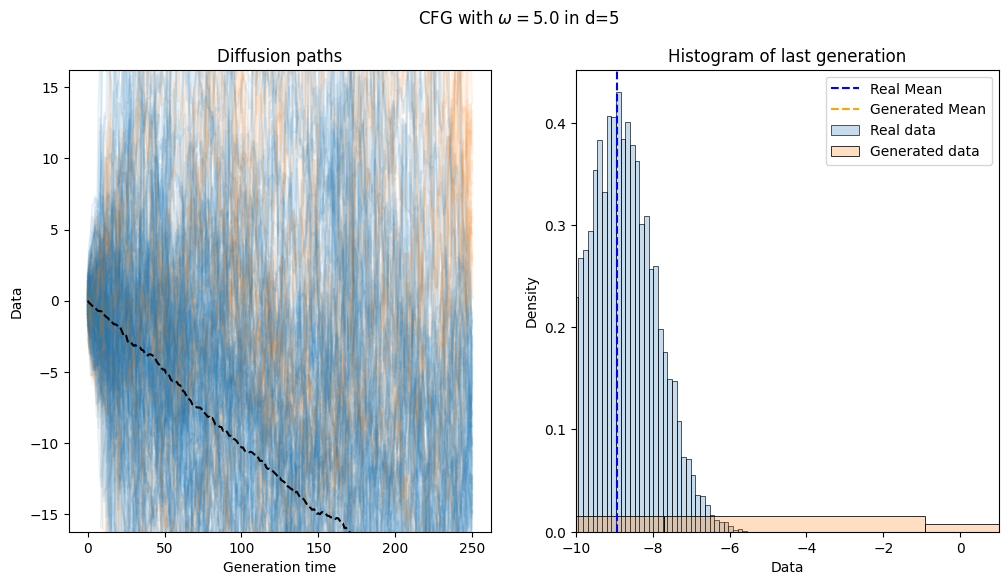

In [371]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for t in samps.T[:200]:
    ax1.plot(t, c='C%d' % int(t[-1] > 0), alpha=0.1)
    
ax1.plot(samps.T.mean(0), c='black', linestyle='--', label='Mean')

sns.histplot(real_samples, ax=ax2, alpha=0.25, label='Real data', stat='density')
sns.histplot(samps[-1, :], ax=ax2, alpha=0.25, label='Generated data', stat='density')
ax1.set_title('Diffusion paths')
ax2.set_title('Histogram of last generation')

ax1.set_xlabel('Generation time')
ax1.set_ylabel('Data')
ax2.set_xlabel('Data')

ax1.set_ylim(torch.abs(torch.tensor([real_samples.min(), real_samples.max()])).max()*torch.tensor([-1.25, 1.25]))
ax2.set_xlim(-10, 1)

ax2.axvline(real_samples.mean(), color='blue', linestyle='--', label='Real Mean')
ax2.axvline(samps[-1, :].mean(), color='orange', linestyle='--', label='Generated Mean')

ax2.legend()
plt.suptitle("CFG with $\omega = %.1f$ in d=%d" % (omega, d))
plt.show()

0.0


0.1
0.2
0.5
0.8
1
2.5
5.0
10.0
15.0


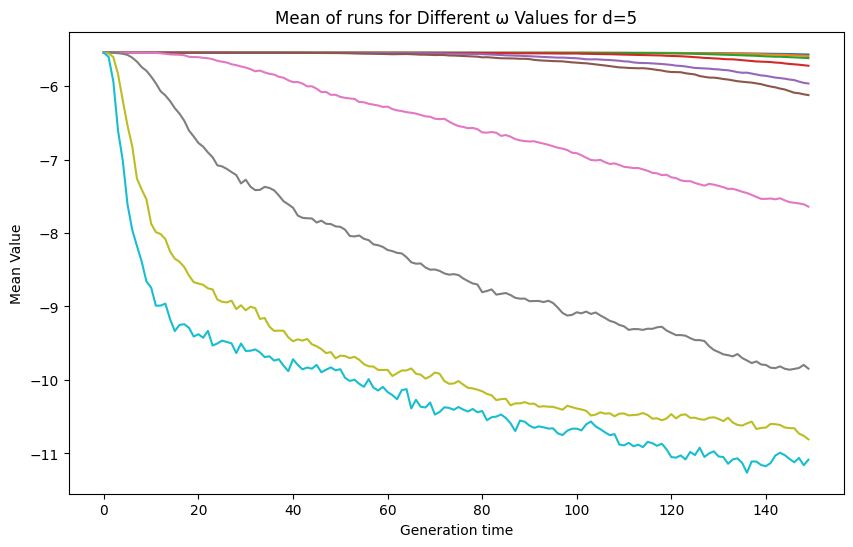

In [374]:
plt.figure(figsize=(10, 6))
for omega in [0., 0.1, 0.2, 0.5, 0.8, 1,2.5, 5., 10., 15.]:#, 25, 30, 50]:
    print(omega)
    samps = torch.stack(sample_reverse(mean_model, var_model, 1000, cfg=True, omega=omega, label=label))
    samps = torch.stack([project(mean1, mean2, s).clamp(min=real_samples.min(), max=real_samples.max()) for s in samps])
    plt.plot(samps.T.mean(0)[:150], label=f'ω = {omega}')

# plt.axhline(y=real_samples.mean(), xmin=0, xmax=250, color='black', linestyle='--', label='Real Mean')
plt.xlabel('Generation time')
plt.ylabel('Mean Value')
plt.title('Mean of runs for Different ω Values for d=5')
# plt.legend()
plt.show()